In [3]:
# general imports
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd                     # not yet fixed in 0.20 by anaconda
import patsy
import statsmodels.formula.api as smf


# GLM I - Lineare Modelle
- Wiederholung *Lineare Modelle* (Achsenabschnitt, Additiv, Interaktion) 
- Einfachstes Generalisiertes Lineares Modell: Lineares Modell mit Normalverteilung
- Beispiel mit Daten: Gehirngewicht % Körpergewicht bei Säugetieren
- Problem: Bestimmen der linearen Abhängigkeit
- Lösung mathematisch:
    - Kleinste-Quadrate-Methode
    - Maximum-Likelihood-Methode
- Lösung mittels Python
    - `pandas`: Datenmanipulation
    - `patsy`: Modellbeschreibung
    - `statsmodels.glm`: Berechnen von (Generaliserten) Linearen Modellen
- Bestes Modell (?)
- Residuen und ihre Verteilung
- Ergebnis und Zusammenfassung

# Statistik
#### Zufallsvariable $Y$ 
- Verteilung, Erwartungswert, Varianz, Form (Schiefe, Kurtosis, ...)
- Parameter der Verteilung ($\mu, \sigma$), ($\lambda$), ...
    - Punktschätzer ($\widehat\mu$), ($\widehat\theta$), ...
    - Konfidenzintervall

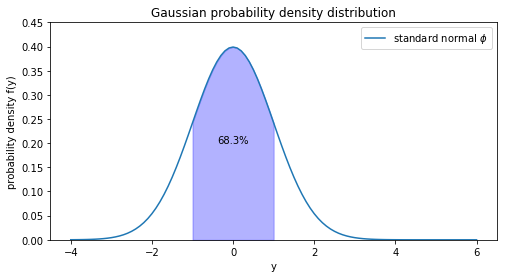

In [4]:
'''Gaussian distribution of random variable y'''
plt.figure(figsize=(8,4))
ys = np.linspace(-4, 6, 101)      # full range
distrib = stats.norm(0, 1)        # freeze to standard normal
plt.plot(ys, distrib.pdf(ys), label='standard normal $\phi$')
y1 = ys[(ys>=-1)&(ys<=1)]         # ROI inbetween +/- 1 sigma 
plt.fill_between(y1, 0, distrib.pdf(y1),    color='b', alpha=0.3)
plt.xlabel('y')
plt.ylabel('probability density f(y)')
plt.text(-.4, .2, '{:.1f}%'.format(100*(distrib.cdf(1)-distrib.cdf(-1))))
plt.ylim(0, .45)
plt.title('Gaussian probability density distribution')
plt.legend(loc='upper right');


#### Zufallsvariable $Y$ 
- Zusätzlich abhängig von einer Variablen $X$: 

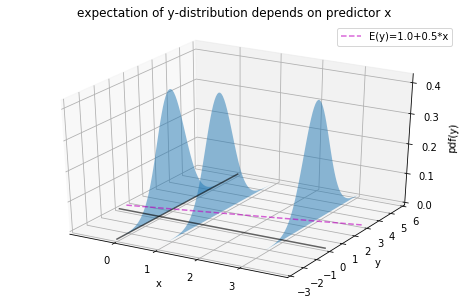

In [3]:
'''expectation of y-distribution depends on predictor x'''
# example from http://matplotlib.org/examples/mplot3d/polys3d_demo.html
from mpl_toolkits.mplot3d import axes3d    # contains 3D
from matplotlib.collections import PolyCollection

beta = [1.0, 0.5]
def g(x):
    return beta[0] + beta[1]*x

fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')     # use 3D -> 2D
xs = np.asarray([0, 1, 3])        # discrete step parameter, in graph restricted to z, is x
ys = np.linspace(-4, 6, 101)      # range of random variable, is y; makes offset 
# empty list: fill with some (3) x-y matrices for each x
verts = []
# cycle through predictors x
for xi in xs:
    # freeze distribution around expectation value depending on x
    distrib = stats.norm(g(xi), 1.)
    zs = distrib.pdf(ys)   # pdf will be height of graph z
    zs[0] = 0              # circumvent filling if borders
    zs[-1] = 0             # ... are non-zero
    verts.append(list(zip(ys, zs)))# stack vector of tuples data together

# tranform to graph-compatible format
poly = PolyCollection(verts)
poly.set_alpha(0.5)   # allows tranparency 50%
ax.add_collection3d(poly, zs=xs, zdir='x') # choose stepping axis (z) as predictor x
xx = np.asarray([-1, 4])          # plot linear dependency y=X*beta in range xx
plt.plot(xx, g(xx), 'm--', alpha=.6, label='E(y)={}+{}*x'.format(beta[0], beta[1]))
plt.plot([-1, 4], [0, 0], 'k-', alpha=.6)  # x-axis
plt.plot([0, 0], [-3, 6], 'k-', alpha=.6)  # y-axis
ax.set_xlabel('x')
ax.set_xlim3d(-1, 4)              # restrict plot
ax.set_xticks([0, 1, 2, 3])       # suppress other x tick labels
ax.set_ylabel('y')
ax.set_ylim3d(-3, 6)
ax.set_zlabel('pdf(y)')
ax.set_zlim3d(0.0, .42)
ax.set_zticks([0, 0.1, 0.2, 0.3, 0.4]) # suppress other x tick labels
ax.set_title('expectation of y-distribution depends on predictor x')
ax.title.set_position([0.5, 1.0]) # workaround distance to legend above
plt.legend(loc='upper right');


$$\begin{align} \mathcal{E}(Y_i) &= \mu_i \\
Y_i\; &\sim \mathcal{N}(\mu_i, \sigma^2)\end{align}$$
mit der Linearen Abhängigkeit
$$ \mu_i = \mathbf{x}_i^T\boldsymbol\beta$$

#### Ausprägung
- nominal 
    - zB. (rot/grün/blau), (f/m), (Städte)
- ordinal
    - zB. (kein/etwas/viel), Schulabschluß
- kardinal/metrisch 
    - zB. Dosis, Stimulusintensität, -Abstand, -Anzahl
- speziell dichotom 
    - zB. (ja/nein), (klein/groß), (0/1) 

# Wiederholung *Lineares Modell*

## Einfaches Lineares Modell:
$$Y = \beta_0 + \beta_1 X$$ 

- abhängige Variable: Zufallsvariable $Y$
    - (mehrfache) Messung, Realisierung, ergibt Wert $y_i$
    - *response*
    - fehlerbehaftet
- unabhängige Variable $X$
    - mit Wert $x_i$, vom Experimentator vorgegeben "*control*"
    - mit Wert $x_i$, fest, mitgemessen "*covariate*"
    - Vorhersageparameter "*predictor*"
- Linearer Zusammenhang 
    - kausale Abhängigkeit $Y$ von $X$
    - Proportionalitätsfaktor $\beta_1$
    - y-Achsenabschnitt $\beta_0$ "*intercept*"
- Streuung zulassen
$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$ 

#### Konventionen
| Schrift         | Bedeutung           | Bsp. |
| :-------------- | :-----------------  | :-: |
| Großbuchstaben  | Zufallsvariable     | $Y$ |
| Kleinbuchstaben | Realisierung einer Zufallsvariable, Meßwert | $x_i, y$ |
| **fett**        | Vektor oder Matrix  | $\mathbf{X}, \mathbf{y}, \boldsymbol{\epsilon}$ |
| Griechisch      | Parameter           | $\beta, \mu$  |
| *Hut* $\widehat{ }$ | Schätzer            | $\widehat\beta_0$ |
| Index $_i$      | Index für Werte     | $x_i$         |
| Index $_j$      | Index für Parameter | $\beta_j$     |
| Index $^{(m)}$  | Index für Iteration | $b^{(m+1)}$   |

### Lineares Modell - Matrix-Schreibweise
Seien $Y_i$ *i.i.d.* Zufallsvariablen mit normalverteilter Streuung $\epsilon$

$$\begin{align}
Y_i &= \beta_0 + \beta_1 X_i + \epsilon_i \qquad & \epsilon_i\sim\mathcal{N}(0, \sigma^2)\\
\mathcal{E}(Y_i) = \mu_i &= \beta_0 + \beta_1 X_i \qquad & Y_i \sim\mathcal{N}(\mu_i, \sigma^2)
\end{align}$$

#### $n$-malige *unabhängige, identische* Wiederholung des Versuchs
- Meßtupel $(X_i,\,Y_i)$ mit $i\in[1\dots n]$
- Erlaubte Streuung in $Y_i$

#### Abhängige Variable $Y$
$$\mathbf{Y} = \begin{bmatrix}Y_1\\ Y_2\\ \vdots\\ Y_n\end{bmatrix}$$

#### Parametervektor $\beta$
$$\boldsymbol\beta = \begin{bmatrix}\beta_0\\ \beta_1 \end{bmatrix}$$

#### Unabhängige Variable $X$
- Vektor $\mathbf{X} = [X_1, X_2,\dots,X_n]^T$
- erweitert um den y-Achsenabschnitt *intercept* 
    - Vektor $\mathbf{1} = [1, 1,\dots, 1]^T$

#### $\Rightarrow$ Designmatrix $\mathbf{X}$
$$\mathbf{X} = \begin{bmatrix} 1 & X_1 \\ 1 & X_2 \\ \vdots & \vdots \\ 1 & X_n \end{bmatrix}$$

#### $\Rightarrow$ Lineares Modell
$$\begin{align}
\begin{bmatrix}Y_1\\ Y_2\\ \vdots\\ Y_n\end{bmatrix} \quad &= 
\begin{bmatrix} 1 & X_1 \\ 1 & X_2 \\ \vdots & \vdots \\ 1 & X_n \end{bmatrix}
\begin{bmatrix}\beta_0\\ \beta_1 
\end{bmatrix} \\
\mathcal{E}(\mathbf{Y}) \quad &= \quad \mathbf{X} \qquad\quad \boldsymbol{\beta} \quad \\
\mathcal{E}(Y_i) \quad &= 1\cdot\beta_0 + X_i\cdot \beta_1 \quad
\end{align}$$

## Das *Additive* Lineare Modell
$k$ unabhängige Variablen $X_j$ als Spalten der Länge $n$ in die **Designmatrix** einfügen

$$ \mathbf{X} = \begin{bmatrix} 
1      & X_{11} & X_{12} & \dots & X_{1k} \\
1      & X_{21} & X_{22} & \dots & X_{2k} \\
\vdots & \;     & \ddots & \;    & \vdots \\
1      & X_{n1} & X_{n2} & \dots & X_{nk}      \end{bmatrix}$$
den **Parametervektor** erweitern zu
$$\boldsymbol\beta = \begin{bmatrix}\beta_0\\ \beta_1\\ \vdots \\\beta_k \end{bmatrix}$$

#### ergibt das additive Lineare Modell

$$\mathcal{E}(\mathbf{Y}) = \mathbf{X}\boldsymbol\beta$$

## Das *Interaktive* Lineare Modell
Sind die unabhängigen Variablen $X_l$ und $X_m$ untereinander unabhängig, dann ist 
$$x_{io} = x_{il}\cdot x_{im}$$
eine *neue* unabhängige Variable und kann als Spalte der Designmatrix hinzugefügt werden.

#### Interaktion: Beeinflussung von $X_l$ auf $X_m$

#### Designmatrix mit einem zusätzlichen <span style="color:red">Interaktions-Term</span>

$$\mathbf{X} = \begin{bmatrix}
1 & x_{1,1} & \dots & x_{1,k}     & {\color{red}{x_{1,k+1}\!=\!x_{1,l}\!\cdot\!x_{1,m}}} \\
\vdots & \vdots & \ddots & \vdots & {\color{red}{\vdots}} \\
1 & x_{n,1} & \dots & x_{n,k}     & {\color{red}{x_{n,k+1}\!=\!x_{n,l}\!\cdot\!x_{n,m}}}
\end{bmatrix}$$

#### Schätzung der Parameter analog 
$$\widehat{\boldsymbol\beta} = [\widehat\beta_0,\;\widehat\beta_1,\dots \widehat\beta_k,\;{\color{red}{\widehat\beta_{lm}}}]^T$$

#### Formelbeschreibung in Patsy beispielsweise
    'y ~ x1 : x2'         # beinhaltet eine Spalte mit Term   x1*x2  in der Designmatrix
    'y ~ x1 * x2 + x3'    # Abkürzung für: Spalten mit Termen 1, x1, x2, x1*x2 und x3

#### alles andere wie gehabt

## Kennwerte Linearer Modelle
### Einzelne Messwerte
$$Y_i = 1\beta_0 + X_{i1}\beta_1 + \dots + X_{ik}\beta_k + \epsilon_i$$

mit Zufall/Streuung/Rauschen ("Homoskedastizitätsannahme",  (Residuen-)Varianzhomogenität)
$$\epsilon \sim \mathcal{N}(0, \sigma^2)$$

Dann
$$\begin{align}
\mathcal{E}(Y_i) &= \beta_0 + X_{i1}\beta_1 + \dots + X_{ik}\beta_k \qquad \\
Var(Y_i) &= \sigma^2
\end{align}$$

### vektoriell
#### Erwartungswert
$$\mathcal{E}(\mathbf{Y}) = \boldsymbol\mu = \mathbf{X}\boldsymbol\beta$$

#### Varianz-Kovarianz-Matrix
$$\mathbf{V}_{jk} = \mathcal{E}\bigl((Y_j-\mu_j)\cdot (Y_k-\mu_k)\bigr)$$
im unabhängigen Fall
$$\begin{align}
Var(Y_j) &= V_{jj} = \sigma_j^2 \\
Cov(Y_j, Y_k) &= V_{jk} = 0 \quad \text{für}\;k \neq j
\end{align}$$
im i.i.d.-Fall
$$Var(Y_j) = V_{jj} = \sigma^2\qquad\quad$$


# *Generalisiertes* Lineares Modell
#### Lineares Modell
$$\mathcal{E}(\mathbf{Y}) = \mathbf{X}\boldsymbol\beta$$

#### Generalisiertes Lineares Modell
mit Link-Funktion $g$
$$\begin{align} \mathcal{E}(\mathbf{Y}) &= \boldsymbol\mu \\
                 g(\boldsymbol\mu) = \boldsymbol\eta     &= \mathbf{X}\boldsymbol\beta \end{align}$$

Insbesonders hilfreich mit
- kategorialer *abhängiger* Variable
- dichotomer *abhängiger* Variable


## Spezialfall
Link-Funktion **Identität**
$$\eta = g(\mu)=\mu$$
Streuung **Normalverteilung**
$$f(\mathbf{Y}) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mathbf{Y}-\mathbf{X}\boldsymbol\beta )^2}{2\sigma^2}\right)$$
Dann ergibt sich
$$\begin{align}
\mathcal{E}(\mathbf{Y})  &= \mathbf{X}\boldsymbol\beta \\
\mathrm{Var}(\mathbf{Y}) &= \sigma^2
\end{align}$$
... das (einfache) **Lineare Modell**

# Fragestellung

#### Das Modell ist festgelegt
- Theorie
- Erfahrung
- Vorversuch

#### Die Modell-Parameter 
- sind unbekannt
- oder dienen der Überprüfung einer Theorie
- gilt es, aus Messungen von $X_i$ und $Y_i$ zu bestimmen

#### Schlußfolgerungen
- Ist $Y$ von $X$ abhängig? (Signifikanz)
- Ist die Abhängigkeit stärker unter Versuchsbedingung A als unter B? (Vergleich)

## Beispielsdatensatz
(aus Vorlesung *Angewandte Statistik I*)

Allison, Cicchetti (1976) *Sleep in mammals: ecological and constitutional correlates.* Science **194:** 732-734 <br> http://www.statsci.org/data/general/sleep.html

In [8]:
%ls -l data/animals.txt

-rw-r--r--. 1 wannek wannek 2873 20. Jan 2016  data/animals.txt


In [9]:
%cat data/animals.txt | head

Species	BodyWt	BrainWt	NonDreaming	Dreaming	TotalSleep	LifeSpan	Gestation	Predation	Exposure	Danger
Africanelephant	6654	5712	NA	NA	3.3	38.6	645	3	5	3
Africangiantpouchedrat	1	6.6	6.3	2	8.3	4.5	42	3	1	3
ArcticFox	3.385	44.5	NA	NA	12.5	14	60	1	1	1
Arcticgroundsquirrel	0.92	5.7	NA	NA	16.5	NA	25	5	2	3
Asianelephant	2547	4603	2.1	1.8	3.9	69	624	3	5	4
Baboon	10.55	179.5	9.1	0.7	9.8	27	180	4	4	4
Bigbrownbat	0.023	0.3	15.8	3.9	19.7	19	35	1	1	1
Braziliantapir	160	169	5.2	1	6.2	30.4	392	4	5	4
Cat	3.3	25.6	10.9	3.6	14.5	28	63	1	2	1


# Python <tt>Pandas</tt> für Umgang mit Daten

#### Homepage:
http://pandas.pydata.org/pandas-docs/stable/overview.html

#### Lizenz:
> pandas is distributed under a 3-clause ("Simplified" or "New") BSD
> license. Parts of NumPy, SciPy, numpydoc, bottleneck, which all have
> BSD-compatible licenses, are included.

#### Installation:
    conda install pandas

#### Links
http://nbviewer.jupyter.org/github/pybokeh/ipython_notebooks/blob/master/pandas/PandasCheatSheet.ipynb

In [10]:
'''pandas library contains useful data manipulation and handling routines'''
import pandas as pd

'''import the dataset from csv file (tab-separated) into a Pandas dataframe object:'''
animals = pd.read_csv('data/animals.txt', sep='\t')  # tab-separated
animals.head(7)

,Species,BodyWt,BrainWt,NonDreaming,Dreaming,TotalSleep,LifeSpan,Gestation,Predation,Exposure,Danger
0,Africanelephant,6654.000,5712.0,NaN,NaN,3.3,38.6,645.0,3,5,3
1,Africangiantpouchedrat,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3,1,3
2,ArcticFox,3.385,44.5,NaN,NaN,12.5,14.0,60.0,1,1,1
3,Arcticgroundsquirrel,0.920,5.7,NaN,NaN,16.5,NaN,25.0,5,2,3
4,Asianelephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624.0,3,5,4
5,Baboon,10.550,179.5,9.1,0.7,9.8,27.0,180.0,4,4,4
6,Bigbrownbat,0.023,0.3,15.8,3.9,19.7,19.0,35.0,1,1,1


In [11]:
print(type(animals))

<class 'pandas.core.frame.DataFrame'>


In [12]:
'''rescale weight because of spread: create new variable from linear data'''
animals['log_BodyWt'] = np.log10(animals['BodyWt'])             # new variable, converted from original
animals['log_BrainWt'] = np.log10(animals['BrainWt'])           # new variable, converted from original
animalsdata = animals[['log_BodyWt', 'log_BrainWt', 'Species']] # focus on list of relevant data
animalsdata = animalsdata.dropna(axis=0)                        # drop lines with invalid data

In [13]:
print(animalsdata.head(7))    # show top of our new pandas-dataframe

   log_BodyWt  log_BrainWt                 Species
0    3.823083     3.756788         Africanelephant
1    0.000000     0.819544  Africangiantpouchedrat
2    0.529559     1.648360               ArcticFox
3   -0.036212     0.755875    Arcticgroundsquirrel
4    3.406029     3.663041           Asianelephant
5    1.023252     2.254064                  Baboon
6   -1.638272    -0.522879             Bigbrownbat


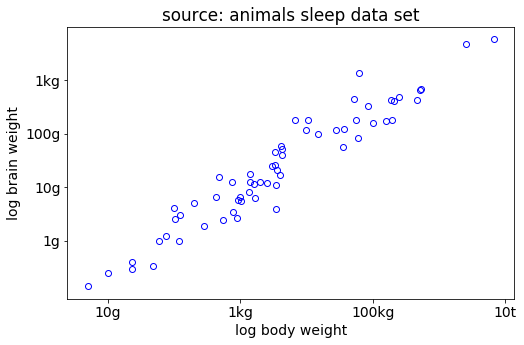

In [14]:
'''show dependency of brain weight ~ body weight (log-log)'''
fig = plt.figure(figsize=(8,5))
# show data
plt.plot(animalsdata['log_BodyWt'], animalsdata['log_BrainWt'],'o', 
         markeredgewidth=1, markeredgecolor='b', markerfacecolor='None')
# Labels
plt.title('source: animals sleep data set')
plt.xticks([-2, 0, 2, 4], ['10g', '1kg', '100kg', '10t']) # unit kg
plt.yticks([0, 1, 2, 3], ['1g', '10g', '100g', '1kg'])    # unit g
plt.xlabel('log body weight')
plt.ylabel('log brain weight');

## Lösung?
Zufällige Abweichungen zwischen Messung $y_i$ und Modell-Vorhersage $\widehat y_i$

#### Residuen 
$$r_i = y_i - \widehat y_i$$

## $\Rightarrow$ Minimale Residuen

#### Summe der Abweichungsbeträge $L_1$
$$ S_1(\mathbf{y},\mathbf{\widehat y}) = \sum_{i=1}^{n} \left|y_i-\widehat y_i \right|$$

#### Element der maximalen Aweichung $L_{\infty}$
$$ S_{\infty}(\mathbf{y},\mathbf{\widehat y}) = max_i(\left|y_i-\widehat y_i \right|)$$

#### Euklidische Abstandsquadratsumme  $L_2$
$$S_2(\mathbf{y},\mathbf{\widehat y}) = \sum_{i=1}^{n} (y_i-\widehat y_i )^2$$
Euklidische Norm: $||\mathbf{z}|| = \sqrt{S_2(\mathbf{z},\mathbf{0})} = \sqrt{\mathbf{z}^T\mathbf{z}} = \sqrt{\sum_{i=1}^{n} z_i^2}$

#### Quadratfehlersumme
$$\mathrm{RSS} = S_2(\mathbf{y},\mathbf{\widehat y}) = \sum_{i=1}^{n} (y_i-\widehat y_i )^2$$
Wird verwendet wenn Gauß'sche Fehler vorhanden sind.

#### Gauß-Markov-Theorem
$L_2$ liefert die kleinste Varianz zu einem erwartungstreuen (*unbiased*) linearen Schätzer
- Voraussetzung: 
    - unabhängige Parameter
    - Fehler *i.i.d.* (*independently identically distributed*)
- Nicht zwingend:
    - Normalverteilung

## Lösung 1: Kleinste Quadrate Schätzer
Für das Lineare Modell
$$\widehat{\mathbf{y}} = \mathcal{E}(\mathbf{Y}) = \mathbf{X}\boldsymbol\beta$$

#### Speziell: Ausgleichsgerade
$$\widehat{\mathbf{y}} = \mathcal{E}(\mathbf{Y}) = \beta_0 + \beta_1 \mathbf{x}$$
Ansatz 
$$S_2(\mathbf{y},\mathbf{\widehat y}) = \sum_{i=1}^{n} r_i^2 = \sum_{i=1}^{n}(y_i-\beta_0-\beta_1 x_i))^2 $$
$$\mathbf{argmin}_{\beta_0, \beta_1}\Bigl( S_2(\mathbf{y},\beta_0,\beta_1,\mathbf{X})\Bigr)$$

führt dank einfacher Rechnung **[ÜA]** zu
$$\begin{align}
\widehat\beta_1 &= \frac{\sum_{i=1}^n (x_i-\overline{x})(y_i-\overline{y})}{\sum_{i=1}^n (x_i-\overline{x})^2} \\
\widehat\beta_0 &= \overline{y} - \widehat\beta_1\overline{x}
\end{align}$$

Residuenvarianz (bereits zwei Werte geschätzt, reduziert Freiheitsgrade)
$$\widehat\sigma^2 = \frac{1}{n-2}\sum_{i=1}^n\widehat\epsilon_i^2 = \frac{1}{n-2}\sum_{i=1}^n(y_i-\widehat\beta_0-\widehat\beta_1 x_i)^2$$

- Gleichgewichtung der (quadratischen) Fehler/Residuen 
- Mit vorhersagbarer Gewichtung $W$ (*unabhänig* vom Parametervektor $\beta$) 

## Lösung 2. Matrix-Ansatz
$$\mathbf{y} = \mathbf{X}\boldsymbol\beta + \boldsymbol\epsilon$$

Minimieren der Fehlerquadratsumme $S_2(\mathbf{y},\mathbf{\widehat y})$

$$\underset{\boldsymbol\beta}{\mathrm{argmin}} \bigl( (\mathbf{y}-\mathbf{X}\boldsymbol\beta)^T(\mathbf{y}-\mathbf{X}\boldsymbol\beta) \bigr)$$

führt zu
$$\mathbf{X}^T\;\mathbf{y} = \mathbf{X}^T\;\mathbf{X}\;\boldsymbol\beta$$
mit Lösung
$$\mathbf{\widehat{\boldsymbol\beta}} = (\mathbf{X}^T\;\mathbf{X})^{-1}\mathbf{X}^T \;\mathbf{y}$$


### Mit Gewichtung
Minimieren der Fehlerquadratsumme mit reziprok gewichteten Varianzen

$$\underset{\boldsymbol\beta}{\mathrm{argmin}} \bigl( (\mathbf{y}-\mathbf{X}\boldsymbol\beta)^T \mathbf{V}^{-1}(\mathbf{y}-\mathbf{X}\boldsymbol\beta) \bigr)$$

(Varianz-Kovarianz-Matrix $\mathbf{V}$; $\;\mathbf{V}_{jk} = \mathrm{Cov}(Y_j, Y_k)\;$)

führt zu

$$\mathbf{X}^T\mathbf{V}^{-1}\mathbf{y} = \mathbf{X}^T\mathbf{V}^{-1}\mathbf{X}\boldsymbol\beta$$
mit Lösung

$$\widehat{\boldsymbol\beta} = \bigl(\mathbf{X}^T \mathbf{V}^{-1}\mathbf{X}\bigr)^{-1}\mathbf{X}^T \mathbf{V}^{-1}\mathbf{y}$$ 

### Implementiert in Python `statsmodels.ols`:
    pinv  # Moore-Penrose pseudoinverse
    qr    # Q-R-Zerlegung

## Lösung 3: Maximum Likelihood Schätzer
Ansatz über Verbund-Wahrscheinlichkeitsverteilung $f_{\boldsymbol\theta}(\mathbf{y})=$ Likelihood $L_{\mathbf{y}}(\boldsymbol\theta)$ 
$$L(\boldsymbol\theta|\mathbf{y}) = f(\mathbf{y}|\boldsymbol\theta) = \prod_{i=1}^{N}f(y_i|\boldsymbol\theta)$$

Daraus Log-Likelihood
$$l(\boldsymbol\theta|\mathbf{y}) := \log L(\boldsymbol\theta|\mathbf{y}) = \sum_{i=1}^{N} \log f(y_i|\boldsymbol\theta)$$
zu maximieren
$$\underset{\boldsymbol\theta}{\mathrm{argmin}} \bigl( l(\boldsymbol\theta|\mathbf{y}) \bigr)$$


### Beispiel Normalverteilung 
- Lineares Modell 
$\qquad \;\mathbf{Y} = \mathbf{X}\boldsymbol\beta + \boldsymbol\epsilon \qquad \boldsymbol\mu = \mathcal{E}(\mathbf{Y}) = \mathbf{X}\boldsymbol\beta$
- Normalverteilung 
$\qquad f(y_i|\,\mu_i, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i-\mu_i)^2}{2\sigma^2}\right)\quad$
- Parametervektor 
$\qquad \boldsymbol\theta = [\beta_0, \beta_1, \sigma]^T$

Log-Likelihood:
$$\begin{align}
l(\boldsymbol\theta) &= \sum_{i=1}^{N} \log f(y_i|\boldsymbol\theta) \\
&= \sum_{i=1}^{N} \log \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i-(\beta_0+\beta_1 x_i))^2}{2\sigma^2} \right) \\
&= -\frac{n}{2}\log 2\pi - n\log\sigma - \frac{1}{2\sigma^2} \sum_{i=1}^{N}\bigl(y_i-(\beta_0+\beta_1 x_i) \bigr)^2
\end{align}$$

Maximieren der Log-Likelihood **[ÜA]** führt zum Parametervektor-Schätzter $\widehat{\boldsymbol\theta} = [\widehat\beta_0, \widehat\beta_1, \widehat\sigma]^T$

$$\begin{align}
\widehat\beta_1  &= \frac{\sum_{i=1}^n (x_i-\overline{x})(y_i-\overline{y})}{\sum_{i=1}^n (x_i-\overline{x})^2} \\
\widehat\beta_0  &= \overline{y} - \widehat\beta_1\overline{x} \\
\widehat\sigma^2 &= \frac{1}{n}\sum_{i=1}^n \left(y_i-(\beta_0+\beta_1 x_i) \right)^2
\end{align}$$

## Ergebnis Anpassung

- Kleinste-Quadrate-Methode
    - Minimiert $S_2$ der Residuen
    - Findet *Kleinste-Quadrate-Schätzer* (*least square, LSE*) für Parameter
- Max-Likelihood-Methode
    - Maximiert Log-Likelihood
    - Findet *Max-Likelihood-Schätzer* (*MLE*) für Parameter
- Meist das selbe Ergebnis
    - Bei Normalverteilung identisch

## Anwendung: log(Gehirnmasse) ~ log(Körpermasse)
#### Design-Matrix
- Zeilen: 
    - Daten der einzelnen Tiere (i)
- Spalten: 
    - unabhängige Variable "Körpergewicht" 
    - Konstante für den y-Achsenabschnitt (*intercept*) $\beta_0$

### 1. Designmatrix mit *numpy*

In [15]:
'''create a design matrix with numpy matrix functions'''
x1 = animalsdata['log_BodyWt']             # select data "log body weight"
print(type(x1), x1.shape)                  # data vector
X1 = np.vstack((np.ones(len(x1)), x1)).T   # tuple of N-vectors -> 2xN ; transpose -> Nx2-array
print(type(X1), X1.shape)                  # design matrix with intercept
print(X1[:5,:])

<class 'pandas.core.series.Series'> (62,)
<class 'numpy.ndarray'> (62, 2)
[[ 1.          3.8230828 ]
 [ 1.          0.        ]
 [ 1.          0.52955867]
 [ 1.         -0.03621217]
 [ 1.          3.40602894]]


### 2. Designmatrix mit *patsy*

# Python <tt>Patsy</tt> zur Formelbeschreibung
**Homepage:** http://patsy.readthedocs.io/en/latest/overview.html    

**Lizenz:**  2-clause BSD

#### Installation:
    conda install patsy
    
#### Verwendung
    import patsy
    # will be used by statsmodels.formula

Formulierung der Datenabhängigkeit im *S-Stil* (wie heute in `R` und früher in `S`)

#### Patsy erlaubt Formulierung
- des Modells
- der zu benutzenden Daten

#### Ausgabe 
- Designmatrix `X` als `patsy.design_info.DesignMatrix`, $N\times K$ Array
- Gemessene Daten `y`  als `patsy.design_info.DesignMatrix`, $N\times 1$ Array

#### Generelle Form
Innerhalb eines Strings $y \sim x$
- links der Tilde die abhängige Variable
- rechts die unabhängigen Variablen

Anschaulich lassen sich die Namen der Datenfelder aus dem `DataFrame` benutzen.

In [16]:
'''patsy automagically creates a design matrix for linear model sleep vs. body weight'''
y, X = patsy.dmatrices('log_BrainWt ~ log_BodyWt', animalsdata)
print(X[:6], '... design matrix X: intercept + independent data')
print(y[:6], '... response vector y: dependent data')

[[ 1.          3.8230828 ]
 [ 1.          0.        ]
 [ 1.          0.52955867]
 [ 1.         -0.03621217]
 [ 1.          3.40602894]
 [ 1.          1.02325246]] ... design matrix X: intercept + independent data
[[3.7567882 ]
 [0.81954394]
 [1.64836001]
 [0.75587486]
 [3.66304097]
 [2.25406445]] ... response vector y: dependent data


### Berechne den Punktschätzer 
des Parametervektors aus Designmatrix und Datenvektor
$$\mathbf{\widehat{\boldsymbol\beta}} = (\mathbf{X}^T\;\mathbf{X})^{-1}\mathbf{X}^T \;\mathbf{y}$$


In [17]:
'''solve pseudo inverse for parameter estimation'''
beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
beta_hat = beta_hat[:, 0]      # make the 2x1 column matrix just an (unspecified) vector
print('mathematical solution for estimate of beta: [{:.4f}  {:.4f}]'
      .format(beta_hat[0], beta_hat[1]))

mathematical solution for estimate of beta: [0.9271  0.7517]


In [18]:
yguess = X.dot(beta_hat)     # matrix-vector-product y = X beta
for i in range(7):           # cycle through lines of y-guess vs. y-measured
    print('X*beta={:6.2f}, measured={:6.2f}'.format(yguess[i], y[i, 0]))

X*beta=  3.80, measured=  3.76
X*beta=  0.93, measured=  0.82
X*beta=  1.33, measured=  1.65
X*beta=  0.90, measured=  0.76
X*beta=  3.49, measured=  3.66
X*beta=  1.70, measured=  2.25
X*beta= -0.30, measured= -0.52


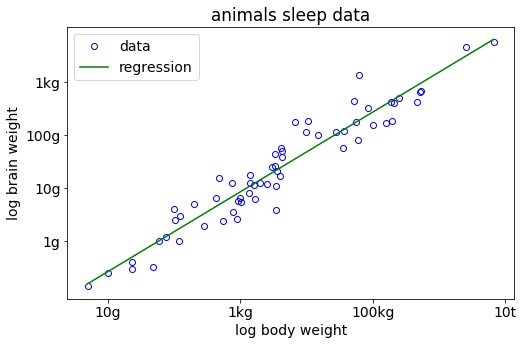

In [19]:
'''show linear dependency for    log(body weight) ~ log(brain weight)'''
fig = plt.figure(figsize=(8,5))
# show data
plt.plot(animalsdata['log_BodyWt'], animalsdata['log_BrainWt'],'o', label='data',
         markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')

# regression line y = f(x) = beta0+beta1*x  with parameters beta[] at value x
def f(x, beta):
    return beta[0] + beta[1]*x

xs = np.asarray([animalsdata['log_BodyWt'].min(), animalsdata['log_BodyWt'].max()])
ys = f(xs, beta_hat)
plt.plot(xs, ys, 'g-', label='regression')   # straight line through extreme points

# Labels
plt.title('animals sleep data')
plt.xticks([-2, 0, 2, 4], ['10g', '1kg', '100kg', '10t'])
plt.yticks([0, 1, 2, 3], ['1g', '10g', '100g', '1kg'])
plt.xlabel('log body weight')
plt.ylabel('log brain weight')
plt.legend(loc='upper left');

#### Ergebnis 
- Proportionalitätsfaktor 
    - nicht 1:1 sondern Steigung etwa 3/4 (log-Einheiten)
    - Logarithmus-Transformation $\Rightarrow$ Exponent 
- Achsenabschnitt 
    - abgelesen etwa -2 (log-Einheiten)
    - $\beta_0$ etwa  1
    - $\Rightarrow$ Obacht: Originaldaten sind Body[kg], aber Brain[g]

# Python <tt>statsmodels</tt> für (lineare) statistische Modelle

#### Links
- Source: https://github.com/statsmodels/statsmodels
- Doku: http://www.statsmodels.org/stable/

#### Lizenz
> Statsmodels is released under the Modified (3-clause) BSD license.

#### Installation
    conda install statsmodels

#### Aufruf
    import statsmodels.api as sm             # complete library
    import statsmodels.formula.api as smf    # patsy formula aware methods


In [20]:
'''usage of statsmodels'''
import statsmodels.api as sm  # import the statsmodels library (with GLM)
help(sm)

Help on module statsmodels.api in statsmodels:

NAME
    statsmodels.api - Statistical models

DESCRIPTION
     - standard `regression` models
    
      - `GLS` (generalized least squares regression)
      - `OLS` (ordinary least square regression)
      - `WLS` (weighted least square regression)
      - `GLASAR` (GLS with autoregressive errors model)
    
     - `GLM` (generalized linear models)
     - robust statistical models
    
      - `RLM` (robust linear models using M estimators)
      - `robust.norms` estimates
      - `robust.scale` estimates (MAD, Huber's proposal 2).
     - sandbox models
      - `mixed` effects models
      - `gam` (generalized additive models)

FILE
    /home/data/anacondaCent/envs/statistikII/lib/python3.6/site-packages/statsmodels/api.py




In [21]:
'''usage of statsmodels with patsy-formula description'''
import statsmodels.formula.api as smf  

'''fit linear Gaussian (default) model with Patsy formula'''
wfit = smf.glm(formula='log_BrainWt ~ log_BodyWt', data=animalsdata).fit()

In [22]:
print(wfit.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:            log_BrainWt   No. Observations:                    62
Model:                            GLM   Df Residuals:                        60
Model Family:                Gaussian   Df Model:                             1
Link Function:               identity   Scale:              0.09091935824611976
Method:                          IRLS   Log-Likelihood:                 -12.626
Date:                Mon, 16 Apr 2018   Deviance:                        5.4552
Time:                        14:24:45   Pearson chi2:                      5.46
No. Iterations:                     2                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9271      0.042     22.227      0.000       0.845       1.009
log_BodyWt     0.7517      0.028     26.409

#### Fit-Ergebnis: Parameter
                   coef  std err         z    P>|z|     [0.025   0.975]
    -------------------------------------------------------------------
    Intercept    0.9271    0.042    22.227    0.000      0.845   1.009
    log_BodyWt   0.7517    0.028    26.409    0.000      0.696   0.807

- Parametervektorschätzer $\quad\widehat{\boldsymbol\beta} = [0.9271 \;0.7517]^T$
- Standardabweichung
- z-Wert der Gauß-Statistik
- p-Wert dazu
- 95%-Konfidenzintervall

#### Fit-Ergebnis: Kennzahlen und Statistiken

    Generalized Linear Model Regression Results                  
    ==============================================================================
    Dep. Variable:            log_BrainWt          # Abhängige Variable
    Model:                            GLM          # (General) Linear Model
    Model Family:                Gaussian          # Standardmethode: Normalverteilung
    Link Function:               identity          # 1:1 linear
    Method:                          IRLS          # Iterative reweighted least squares
    No. Iterations:                     2          # Schritte
    No. Observations:                  62          # Beobachtungen i=1..62
    Df Residuals:                      60          # Freiheitsgrade Residuen
    Df Model:                           1          # Freiheitsgrade (ohne intercpt)
    Pearson chi2:                    5.46          # Pearson-Statistik (o-e)^2/e


In [23]:
'''extract parameters and values'''
b, m = wfit.params                                   # beta parameters: intercept and gain
print('regression            y  =       {:.3f}*x   +      {:.3f}   +  epsilon'.format(m, b))   
cib = (wfit.conf_int()[0][0], wfit.conf_int()[1][0]) # 1st ci[lower, upper] of intercept
cim = (wfit.conf_int()[0][1], wfit.conf_int()[1][1]) # 2nd ci[lower, upper] of gain
print('regression parameters CI = {}, {}'            #
      .format(np.round(cim, decimals=3), np.round(cib, decimals=3))) 
print('deviations epsilon ~ N({:.5f}, {:.5f})'       # distribution of residuals
      .format(wfit.resid_response.mean(), wfit.resid_response.var(ddof=1+wfit.df_model))) 

regression            y  =       0.752*x   +      0.927   +  epsilon
regression parameters CI = [0.696 0.807], [0.845 1.009]
deviations epsilon ~ N(-0.00000, 0.09092)


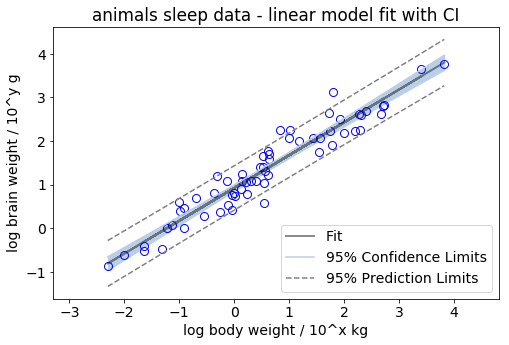

In [24]:
'''fit linear model to data: confidence intervals of prediction and point estimate'''
# get data
x = np.asarray(animalsdata['log_BodyWt'])            # extract independent variable
y = np.asarray(animalsdata['log_BrainWt'])           # extract dependent variable
y_hat = np.asarray(wfit.fittedvalues)                # estimated linear result
x_bar = x.mean()

# Statistics
t = stats.t.ppf(0.95, wfit.df_resid)   # used for CI and PI bands according to residual's degree-of-freedom

# Estimates of Error in Data/Model           
s_err = np.sqrt(np.sum(wfit.resid_response**2)/(wfit.df_resid))   # standard deviation of the error

fig = plt.figure(figsize=(8,5))
# show data
plt.plot(x, y,'o', color='#b9cfe7', markersize=8,
         markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')
# show fit
plt.plot(x, y_hat,'-', color='0.1', linewidth=2, alpha=0.5, label='Fit')  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = np.linspace(np.min(y_hat), np.max(y_hat), 100)    # IF SLEEP: reverse due to decrease

# confidence interval
CI = t*s_err*np.sqrt(1/len(x) +(x2-x_bar)**2/np.sum((x-x_bar)**2))
plt.fill_between(x2, y2+CI, y2-CI, color='#b9cfe7', edgecolor='')
# Minor hack for labeling CI fill_between()
plt.plot(x2, y2+CI, '-', color='#b9cfe7', label='95% Confidence Limits')

# Prediction Interval
PI = t*s_err*np.sqrt(1+1/len(x)+(x2-x_bar)**2/np.sum((x-x_bar)**2))   
plt.fill_between(x2, y2+PI, y2-PI, color='None', linestyle='--')
plt.plot(x2, y2-PI, '--', color='0.5', label='95% Prediction Limits')
plt.plot(x2, y2+PI, '--', color='0.5')

# Labels
plt.title('animals sleep data - linear model fit with CI')
plt.xlabel('log body weight / 10^x kg')
plt.ylabel('log brain weight / 10^y g')
# plt.legend(loc=9, bbox_to_anchor=(0, -0.21, 1., .102), ncol=3, mode='expand')
plt.legend(loc='lower right')
plt.xlim(np.min(x)-1,np.max(x)+1);

## Daten interpolieren, extrapolieren
Modell an die Daten apassen (*fit*) ergibt den Parameter-Schätzer
$$\widehat{\boldsymbol\beta}$$

Der vorhergesagte Wert $\widehat{\mathbf{y}}$ ist
$$\widehat{\mathbf{y}} = \mathbf X \widehat{\boldsymbol{\beta}}$$

$$\widehat y_i = (\mathbf X \widehat{\boldsymbol{\beta}})_i = \sum_{j=0}^m x_{ij} \widehat\beta_j = 1 \widehat\beta_0 + x_{i1}\widehat\beta_1 + x_{i2}\widehat\beta_2 + ... + x_{im}\widehat\beta_m $$

In [25]:
'''predict three animals of interest'''
x = np.asarray([np.log10(.002), 
                animalsdata[(animalsdata['Species']=='Man')]['log_BodyWt'], 
                np.log10(1.8E5)])         # 2g, 62kg, 180to
xdf = pd.DataFrame({'log_BodyWt': x})     # make a datafram with suitable column
y_hat = wfit.predict(xdf)                 # make use of built-in method
for xi, xp in zip(x, y_hat):              # show all three results
    print('animal with body weight {:12.4f}kg has a linearly predicted brain weight of {:9.2f}g'
          .format( 10**xi, 10**xp))

animal with body weight       0.0020kg has a linearly predicted brain weight of      0.08g
animal with body weight      62.0000kg has a linearly predicted brain weight of    188.12g
animal with body weight  180000.0000kg has a linearly predicted brain weight of  75412.16g


# Bestes Modell?
Ein perfekt passendes Modell muß nicht das beste sein ... ... ...

Gleiche Versuchsbedingung, identische Zeile in Designmatrix: Streuung in $\mu_{i_1}=\mu_{i_2}=\dots$

$\Rightarrow$ Fehler zulassen
$$\mathbf{y} = \boldsymbol\mu + \boldsymbol{\epsilon}$$

- Theorie
- Ockhams' razor

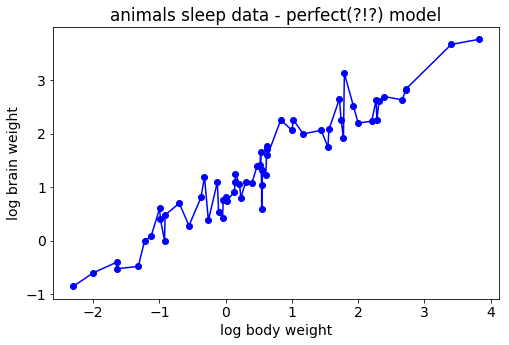

In [26]:
'''useless "perfect" model'''
fig = plt.figure(figsize=(8,5))
# show data
plt.plot(animalsdata['log_BodyWt'], animalsdata['log_BrainWt'], 'bo')       # raw data
animals_sorted = animalsdata.sort_values(by='log_BodyWt', ascending=False)  # after sorting...
plt.plot(animals_sorted['log_BodyWt'], animals_sorted['log_BrainWt'], 'b-') # ... raw data connected
# Labels
plt.title('animals sleep data - perfect(?!?) model')
plt.xlabel('log body weight')
plt.ylabel('log brain weight');

In [27]:
'''search for the big jumps around body weight of 70kg'''
print(animals_sorted.loc[(1.6<animalsdata['log_BodyWt']) & (animalsdata['log_BodyWt']<=1.8)])

    log_BodyWt  log_BrainWt         Species
33    1.792392     3.120574             Man
19    1.778151     1.908485  Giantarmadillo
53    1.744293     2.243038           Sheep
9     1.717338     2.643453      Chimpanzee


## Ergebnis

Modell = Entscheidung für Vereinfachung

#### Overfitting
John von Neumann:
* With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.

#### Residuen
Es verbleiben zwangsläufig Residuen:

# Verteilung der Residuen
### Modell
$$\begin{align}
Y_i &= \mathbf{X}^T_i \boldsymbol\beta + \epsilon_i \qquad & \epsilon_i\sim\mathcal{N}(0, \sigma^2)\\
\mathcal{E}(Y_i) = \mu_i &= \mathbf{X}^T_i \boldsymbol\beta \qquad & Y_i \sim\mathcal{N}(\mu_i, \sigma^2)
\end{align}$$


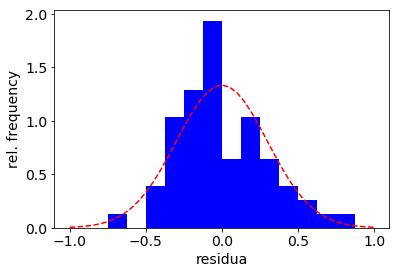

In [31]:
'''log brain weights residuals'''
bins=np.linspace(-1., 1., 17)
x = np.linspace(-1., 1., 41)
plt.hist(wfit.resid_response, bins, color='b', density=True)                         
mu, sigma = (wfit.resid_response.mean(), wfit.resid_response.std()) # estimated distribution
plt.plot(x, stats.norm(mu, sigma).pdf(x), 'r--')                    # ... as Gaussian graphics
plt.xlabel('residua')
plt.ylabel('rel. frequency');    

Die Residuen scheinen etwas rechts-schief verteilt zu sein.

In [32]:
print('skew = {:.3f}'.format(wfit.resid_response.skew()))

skew = 0.416


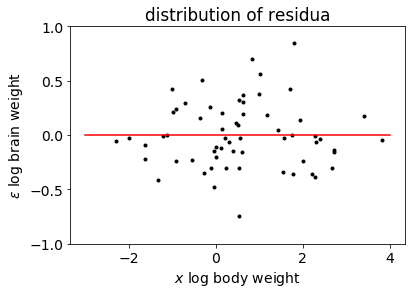

In [33]:
'''log brain weights residual'''
plt.plot(animalsdata['log_BodyWt'], wfit.resid_response, 'k.')
plt.plot([-3., 4.], 2*[0], 'r-')
plt.ylim(-1, 1)
plt.xlabel('$x$ log body weight')
plt.ylabel('$\epsilon$ log brain weight')
plt.title('distribution of residua');

### Anforderung an Residuen
- Modell soll gut abbilden, "in der Mitte" $\quad \Rightarrow \quad \mathcal{E}(R)=0$
- Streung in Verteilung hat dieselben Ursachen
    - *Lineares Modell*, *Gauß*-Verteilung: $\; \Rightarrow \quad Var(R)=const.$
    - Gemäß Verteilung
- Gutes Modell erklärt die Messdaten
    - Keine (wenig) Information in den Residuen: $\quad \Rightarrow$ **unabhängig**, homoskedastisch

### Residuen
*Homoskedastizität* und *Unabhängigkeit*

Systematische Abweichungen? auf den Grund gehen! 
<img src="images/resid-plots.gif">

Beispiele (von [hier](http://www.r-bloggers.com/model-validation-interpreting-residual-plots/))

# Ergebnis lineare Modelle in Python
- Daten lassen sich in `DataFrames` komfortabel bearbeiten
- lassen sich durch `Patsy`-Formel beschreiben
- Schätzer für Parameter lassen sich durch `statsmodels.glm` berechnen
- Rückgabewerte:
    - Kennzahlen
    - Statistiken
    - Punktschätzer für Parameter (Steigung und Achsenabschnitt) und deren
    - Intervallschätzer
    - ...

# Zusammenfassung *lineares Modell*

$$\begin{align} & \mathbf{y}  &= \mathbf{X} \,\boldsymbol{\beta} & + \mathbf{\epsilon} \qquad\\
    \mathcal{E}(& \mathbf{y}) &= \mathbf{X} \,\boldsymbol{\beta} &   \qquad \end{align}$$

- $\mathbf{y}$ Werte der interessierenden abhängigen Variable
- $\mathbf{X}$ Designmatrix mit
    - unabhängigen Variablen in den Spalten
    - Indikator- (Pseudo-) Variablen für unabhängige Kategorien
- $\boldsymbol{\beta}$ Modell-Parameter
    - bestimmt die Modell-Abhängigkeit $y_i \sim x_i$
- $\epsilon$ Streuungen in $y$.
    - Meßfehler
    - Ungenauigkeiten
    - Residuen: Abweichungen vom Modell

$$\begin{align} & \mathbf{y}  &= \mathbf{X} \,\boldsymbol{\beta} & + \mathbf{\epsilon} \qquad\\
    \mathcal{E}(& \mathbf{y}) &= \mathbf{X} \,\boldsymbol{\beta} &   \qquad \end{align}$$

### Gesucht
die Parameter des Modells $\boldsymbol\beta$

### Lösung dieser Aufgabe
mittels Anpassen der Parameter durch iterative Anwendung von Matrixinversion aus Maximum-Likelihood-Prinzip / Kleinste-Quadrate-Schätzung 

### Ergebnis
Parametervektor $\boldsymbol\beta$
- Punktschätzer $\widehat{\boldsymbol\beta}$ mit Konfidenzintervall
- *Signifikanz*

# Zusammenfassung Python pandas
- Daten aus Datei einlesen `read_csv()`
- Variable vom Typ `DataFrame`
    - Auswahl der in Spalten enthaltenen Variablen durch Namensstring 
    - Auswahl nach Kriterien, Index, Eigenschaften, ...
    - Umfangreiche Methoden
        - Sortieren `sort()`
        - ...

# Zusammenfassung Python patsy
<br>

    y, X = patsy.dmatrices('yvar ~ xvar1 + xvar2', df)

- verwendet *pandas* `DataFrame df`
- Designmatrix `X` mit y-Achsenabschnittskonstante
- Vektor `y` der abhängigen Variablen 

### Formelzeichen in *Patsy*-String

    ~  Separate the left-hand side from the right-hand side. 
          If omitted, formula is assumed right-hand side only.
    +  Combines terms on either side (set union).
    -  Removes terms on the right from set of terms on the left
          (set difference).
    *  a*b is shorthand for the expansion a + b + a:b.
    /  a/b is shorthand for the expansion a + a:b. 
          It is used when b is nested within a (e.g., states and counties)
    :  Computes the interaction between terms on the left and right.
    ** Takes a set of terms on the left and an integer n on the right 
          and computes the * of that set of terms with itself n times.

# Zusammenfassung Python `statsmodels`
### `statsmodels.formula.glm.fit()`
beschreibt ein **lineares Datenmodell**

#### Eingabe Datensatz ` data=`
`pandas.DataFrame` mit *Variablennamen*
- unabhängige Variablen bzw. Designmatrix
- abhängigen Variablen

#### Eingabe Modell `formula=`
`patsy`-Formel mit abhängiger Variable ~ unabhängigen Variablen
- `'y ~ x1 + x2 + x3'`
- berücksichtigt bereits die Konstantenspalte der Designmatrix *intercept*
    - explizit ausschließen `'~ -1'`

### `statsmodels.GLM.fit()`

#### Eingabe Daten
- `exog` : unabhängige Variablen in Spalten der Designmatrix $\mathbf{X}$ 
    - zusätzlich Konstante *intercept* anfügen `sm.add_constant(X)`
    - Bei *Interaktion* sind zusätzliche Spalten zu berechnen
- `endog` : abhängige Variable, gemessene Daten $\mathbf{y}$


### `statsmodels.___.fit()`

#### Ausgabe Parametervektor
- Punktschätzer
    - Standardabweichung
    - Vertrauensintervall
    - Z-Wert der Gauß-Statistik
    - p-Wert

#### Ausgabe Statistiken und Kennzahlen
- ...

#### Ausgabe Fit-Werte
- `fittedvalues`:   (als pandas-Daten-`Series`)
- `resid_response`: verbleibende Fehler (`Series`)
- `predict(x)`:      Zwischenwerte vorhersagen / Extrapolieren
    - x als DataFrame mit passend benannten Spalten